Before the computation of the RFs, we apply a pair of exponential
weighting functions with a half width of 30 s and centered at the
theoretical arrival time of the PP-phase (t pp ) to reduce the ampli-
tude of the PP phase on the vertical, N–S, and E–W components.
This step is necessary for reducing the degenerating effect to the
resulting RFs by the PP arrivals which have very different ray pa-
rameters than the P-waves

In [1]:
%matplotlib inline

In [104]:
import numpy as np
import obspy as op
import glob
import os
import shutil
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [3]:
#Recolhendo os dados de cada estação

#Nome	Latitude	Longitude
#BPPF	-6.2271	-47.2518	
#STSN	-6.0787	-46.5986 
#GRJU	-5.8308	-46.0882 
#GENI	-5.4612	-45.5344
#PRDT	-5.3241	-44.3974
#TRZN	-5.1056	-42.6344
#BUCO	-5.1586	-43.2010
#STSR	-5.2889	-43.8063

STA_name = 'BPPF'	
STA_la = -6.2271		
STA_lo = -47.2518



In [156]:
dir_sac = '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine/iasp91_2s/'
dir_sac_filter_PP = '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine_filter_PP/iasp91_2s/'

datalist = []
datalistS = []

for root, dirs, files in os.walk(dir_sac+STA_name+'/'):
    for datafile in files:
        if datafile.endswith('.Z'):
            datalist.append(os.path.join(root, datafile))

datalistS = sorted(datalist)
dir_name = [i.split('SYN.')[0] for i in datalistS]
name_file = [i.split('/')[-2] for i in dir_name]

dir_name = dir_name[0:2]
name_file = name_file[0:2]
#Cortando os aquivos em cada pasta de acordo com o evento:


In [157]:
name_file

['2016.4.35.20', '2016.2.42.33']

In [158]:
dir_name

['/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine/iasp91_2s/BPPF/2016/190/2016.4.35.20/',
 '/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine/iasp91_2s/BPPF/2016/192/2016.2.42.33/']

In [159]:
for i,j in enumerate(dir_name):
    #Calculando a distância, o azimute e o backazimute
    print('Diretório atual = '+j)		
    os.chdir(j)	
    dir_PP_name = j.split('/iasp91_2s/')[1]		
    print(dir_sac_filter_PP+dir_PP_name+'SYN.'+STA_name+'.'+name_file[i])	
#os.makedirs(dir_sac_filter_PP+dir_PP_name, exist_ok=True)	

    HHX = op.read('*.E')

    #HHX.detrend() 
    #HHX.taper(type='hamming',max_percentage=0.02) 
    #HHX.filter('lowpass',freq=4,zerophase=True) 
    #HHX.filter('highpass',freq=0.05,zerophase=True)

    #Calculando o tempo da onda PP
    model = TauPyModel(model="iasp91")
    arrivalsP = model.get_travel_times(source_depth_in_km=HHX[0].stats.sac.evdp/1000, distance_in_degree=HHX[0].stats.sac.gcarc, phase_list=["P"])
    arrP = arrivalsP[0]	

    arrivalsPP = model.get_travel_times(source_depth_in_km=HHX[0].stats.sac.evdp/1000, distance_in_degree=HHX[0].stats.sac.gcarc, phase_list=["PP"])
    arrPP = arrivalsPP[0]	
    
    time_PP = arrPP.time - arrP.time
    print(time_PP)

Diretório atual = /home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine/iasp91_2s/BPPF/2016/190/2016.4.35.20/
/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine_filter_PP/iasp91_2s/BPPF/2016/190/2016.4.35.20/SYN.BPPF.2016.4.35.20
74.63597520131196
Diretório atual = /home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine/iasp91_2s/BPPF/2016/192/2016.2.42.33/
/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine_filter_PP/iasp91_2s/BPPF/2016/192/2016.2.42.33/SYN.BPPF.2016.2.42.33
130.41912509249482


In [80]:
data_HHX = []
for k,l in enumerate(HHX[0].times()):
    if time_PP - 30.0 <= l <= time_PP - 5.0:
        data_HHX.append(HHX[0].data[k] * np.exp(-0.2*(l - time_PP + 30.0)))
    elif time_PP - 5.0 <= l <= time_PP + 5.0: 
        data_HHX.append(HHX[0].data[k] * 0.0)
    elif time_PP + 5.0 <= l <= time_PP + 30.0: 
        data_HHX.append(HHX[0].data[k] * np.exp(-0.2*(-l + time_PP + 30.0)))
    else:
        data_HHX.append(HHX[0].data[k])

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f8fa529c7f0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f8fa529cf98>)

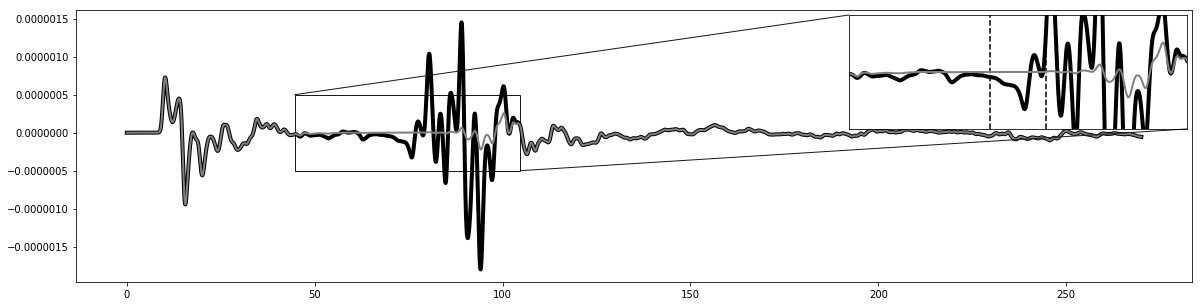

In [136]:
fig, ax = plt.subplots(figsize = (20,5)) # create a new figure with a default 111 subplot

ax.plot(HHX[0].times(),HHX[0].data,color='k',lw=4)
ax.plot(HHX[0].times(),data_HHX,'-',color='gray',lw=2)


axins = zoomed_inset_axes(ax, 1.5, loc='upper right') # zoom-factor: 2.5, location: upper-left
x1, x2, y1, y2 = time_PP - 30.0, time_PP + 30.0, -0.0000005, 0.0000005 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2)
axins.plot(HHX[0].times(),HHX[0].data,color='k',lw=4)
axins.plot(HHX[0].times(),data_HHX,color='gray',lw=2)
axins.set_yticks([])
axins.set_xticks([])
axins.vlines(time_PP - 5.0,-0.0000005,0.0000005,linestyles='dashed')
axins.vlines(time_PP + 5.0,-0.0000005,0.0000005,linestyles='dashed')
mark_inset(ax, axins, loc1=2, loc2=4, facecolor="gray", ec="0.1")